# Data Science in Practice 2020

## Problem Set 2

### Descriptive report

Authors :
- Rayan Chaouche
- Yann Martinson
- Christopher Padovani
- Jules Triomphe

### 1. Initialization

#### 1.1 Primary analysis

Loading modules :

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss, classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import time
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, precision_recall_curve, auc
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pyplot
from operator import itemgetter, attrgetter
from scipy.stats import randint as sp_randint
from sklearn import metrics

## Functions

In [2]:
def df_preprocessing() :
    
    df_raw = pd.read_csv('customers.csv')
    
    # clean up lines
    
    total_length = len(df_raw)
    df_raw = df_raw[df_raw['TotalCharges'] != ' ']
    df_raw.TotalCharges = df_raw.TotalCharges.astype('float')
    cleanup_length = len(df_raw)
    print('%s lines were deleted.' %(total_length - cleanup_length))
    
    # output into dummies
    
    churn_dummy_dict = {'Yes': 1, 'No': 0}
    df_raw.Churn.replace(churn_dummy_dict, inplace = True)
    
    # X y splitting
    
    y = df_raw.Churn.copy()
    X_raw = df_raw.drop(columns ='Churn').copy()
    
    # input into dummies
    
    X_raw_types = dict(X_raw.dtypes)
    features = list(X_raw.columns)
    categorical_features = [feat for feat in features if X_raw_types[feat] == 'O']
    categorical_features.remove('customerID')
    
    X = pd.get_dummies(X_raw, columns = categorical_features,prefix_sep=':')
    X = X.drop(columns = 'customerID').copy()
    
    # train val splitting
    
    train = np.random.rand(cleanup_length)> 0.3

    X_train = X[train]
    X_val = X[~train]

    y_train = y[train].tolist()
    y_val = y[~train].tolist()

    
    return df_raw,categorical_features, X, X_train, X_val, y, y_train, y_val

In [3]:
def plot_importance(feature_importance_sorted, n, type_of_search):
    
    plt.figure(figsize=(15,5))
    x = np.arange(n)
    y = [feature_importance_sorted[i][1] for i in range(n)]
    labels = [feature_importance_sorted[i][0] for i in range(n)]
    ax = sns.barplot(y,x,orient="h");
    plt.xlabel("Importance fraction", fontsize = 12)
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    plt.yticks(x,labels, fontsize = 15)
    plt.title('Most important feature: {}'.format(type_of_search), fontsize = 15)
    plt.show()

In [4]:
df_raw,categorical_features, X, X_train, X_val, y, y_train, y_val = df_preprocessing()

11 lines were deleted.


As we want to avoid some over fitting, we will first separate the set in two distinct sets, train and validate, which will allow us to test the model on some unseen data. We make a random 80% - 20% split of the data.

#### Random Forest Classifier

We will compare two methods, which are grid search and random search.

In [5]:
clf = RandomForestClassifier(n_jobs=-1)

# Grid search
To avoid too high a computational time, we will focus on 2 of the mot important parameters that are max depth and the number of estimators.

#### Max Depth
This parameter is the depth of the trees, which is one of the most important. We range it between 4 (anything lower seems too low and imcreases computational time without much results) and 15.

#### Number of estimators
This parameter is the number of trees that are going to be generated. Here the choice of the number of trees will mostly affect the computational time. Let's set the values between 10 and 500 and see the effects.

In [6]:
max_depth = list(range(4,16))

In [7]:
n_estimators = [10, 15, 20, 50, 100, 200, 500]

Let's use the default 5 folds of cross validation.

In [8]:
grid_parameters = {'max_depth':max_depth, 'n_estimators': n_estimators }

In [9]:
grid_clf = GridSearchCV(clf, param_grid = grid_parameters, verbose = 3)

In [10]:
grid_clf.fit(X_train, y_train)

=11, n_estimators=500, score=0.790, total=   2.3s
[CV] max_depth=12, n_estimators=10 ...................................
[CV] ....... max_depth=12, n_estimators=10, score=0.808, total=   0.1s
[CV] max_depth=12, n_estimators=10 ...................................
[CV] ....... max_depth=12, n_estimators=10, score=0.784, total=   0.1s
[CV] max_depth=12, n_estimators=10 ...................................
[CV] ....... max_depth=12, n_estimators=10, score=0.770, total=   0.1s
[CV] max_depth=12, n_estimators=10 ...................................
[CV] ....... max_depth=12, n_estimators=10, score=0.766, total=   0.1s
[CV] max_depth=12, n_estimators=10 ...................................
[CV] ....... max_depth=12, n_estimators=10, score=0.788, total=   0.1s
[CV] max_depth=12, n_estimators=15 ...................................
[CV] ....... max_depth=12, n_estimators=15, score=0.799, total=   0.1s
[CV] max_depth=12, n_estimators=15 ...................................
[CV] ....... max_depth=12, 

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              rand

Let's check which model is the best.

In [11]:
grid_best_score = grid_clf.best_score_
grid_best_parameters = grid_clf.best_params_
grid_best_max_depth = grid_best_parameters.get('max_depth')
grid_best_n_estimators = grid_best_parameters.get('n_estimators')

print('Grid search best_score: {}'.format(grid_best_score))
print('best_max_depth: {}'.format(grid_best_max_depth))
print('best_n_estimators: {}'.format(grid_best_n_estimators))

Grid search best_score: 0.8062627641962031
best_max_depth: 7
best_n_estimators: 200


In [12]:
grid_clf_best = RandomForestClassifier(n_jobs = -1,max_depth = grid_best_max_depth, n_estimators = grid_best_n_estimators )

In [13]:
grid_clf_best.fit(X_train, y_train);

Let's apply it to our validation set.

In [14]:
grid_y_pred = grid_clf_best.predict(X_val)

In [15]:
print("Accuracy:",metrics.accuracy_score(y_val, grid_y_pred))

Accuracy: 0.7986348122866894


Given this accuracy, we can take a deeper look into the results.

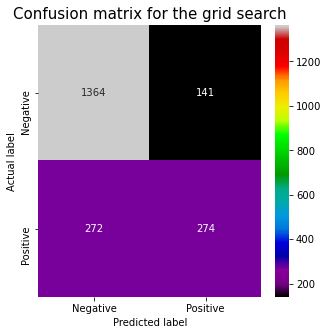

In [16]:
grid_cm = confusion_matrix(y_val, grid_y_pred)
index = ['Negative','Positive']  
columns = ['Negative','Positive']  
cm_df = pd.DataFrame(grid_cm,columns,index) 


plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix for the grid search', fontsize = 15);

### Feature importance

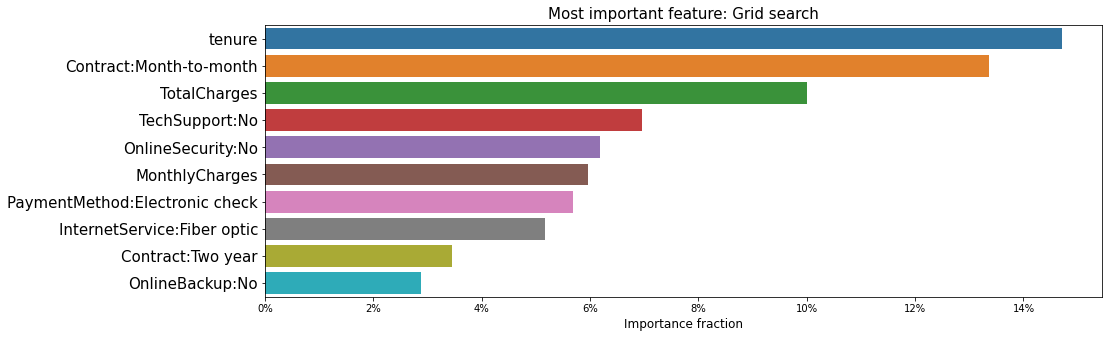

In [17]:
grid_feature_importances = [(list(X.columns)[i], grid_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
grid_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(grid_feature_importances, 10, 'Grid search')

In [18]:
print(classification_report(y_val,grid_y_pred))

precision    recall  f1-score   support

           0       0.83      0.91      0.87      1505
           1       0.66      0.50      0.57       546

    accuracy                           0.80      2051
   macro avg       0.75      0.70      0.72      2051
weighted avg       0.79      0.80      0.79      2051



### Feature selection
Let's try to run the model again, but this time selecting only the most impacting features to save us some work and let's compare the results.

In [19]:
grid_selected_features = [grid_feature_importances[i][0] for i in range(15)]
grid_X_train_sel = X_train[grid_selected_features]
grid_X_val_sel = X_val[grid_selected_features]

In [20]:
grid_clf.fit(grid_X_train_sel, y_train)

=11, n_estimators=500, score=0.785, total=   2.5s
[CV] max_depth=12, n_estimators=10 ...................................
[CV] ....... max_depth=12, n_estimators=10, score=0.795, total=   0.1s
[CV] max_depth=12, n_estimators=10 ...................................
[CV] ....... max_depth=12, n_estimators=10, score=0.792, total=   0.1s
[CV] max_depth=12, n_estimators=10 ...................................
[CV] ....... max_depth=12, n_estimators=10, score=0.766, total=   0.1s
[CV] max_depth=12, n_estimators=10 ...................................
[CV] ....... max_depth=12, n_estimators=10, score=0.787, total=   0.1s
[CV] max_depth=12, n_estimators=10 ...................................
[CV] ....... max_depth=12, n_estimators=10, score=0.778, total=   0.1s
[CV] max_depth=12, n_estimators=15 ...................................
[CV] ....... max_depth=12, n_estimators=15, score=0.791, total=   0.1s
[CV] max_depth=12, n_estimators=15 ...................................
[CV] ....... max_depth=12, 

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              rand

In [21]:
grid_best_score_sel = grid_clf.best_score_
grid_best_parameters_sel = grid_clf.best_params_
grid_best_max_depth_sel = grid_best_parameters.get('max_depth')
grid_best_n_estimators_sel = grid_best_parameters.get('n_estimators')
print('Grid search best_score with selected features: {}'.format(grid_best_score_sel))
print('Grid search best_max_depth with selected features: {}'.format(grid_best_max_depth_sel))
print('Grid search best_n_estimators with selected features: {}'.format(grid_best_n_estimators_sel))

Grid search best_score with selected features: 0.8008414802640853
Grid search best_max_depth with selected features: 7
Grid search best_n_estimators with selected features: 200


In [22]:
grid_clf_best_sel = RandomForestClassifier(n_jobs = -1,max_depth = grid_best_max_depth_sel, n_estimators = grid_best_n_estimators_sel )

In [23]:
grid_clf_best_sel.fit(grid_X_train_sel, y_train);

In [24]:
grid_y_pred_sel = grid_clf_best_sel.predict(grid_X_val_sel)

In [25]:
print("Accuracy:",metrics.accuracy_score(y_val, grid_y_pred_sel))

Accuracy: 0.7991223793271575


# Random Search

After having explored a grid search, we can adopt another approach. Instead of searching for each value, let's give our model more parameters input, but instead let it choose randomly at each iteration one value for each parameter. It will then be evaluated again.

In [26]:
n_estimators = range(10,1000,50)
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2', None]
bootstrap = [True,False]
max_depth = range(5,50,10)
min_samples_leaf = range(2,100, 2)
min_samples_split = range(2,100,2)

random_parameters = {'n_estimators':n_estimators, 'max_features':max_features, 'max_depth':max_depth, 'min_samples_leaf':
              min_samples_leaf}


In [27]:
random_clf = RandomizedSearchCV(clf, param_distributions = random_parameters, n_iter = 20, verbose = 3)

In [28]:
random_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=10, min_samples_leaf=96, max_features=sqrt, max_depth=25 
[CV]  n_estimators=10, min_samples_leaf=96, max_features=sqrt, max_depth=25, score=0.797, total=   0.1s
[CV] n_estimators=10, min_samples_leaf=96, max_features=sqrt, max_depth=25 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV]  n_estimators=10, min_samples_leaf=96, max_features=sqrt, max_depth=25, score=0.801, total=   0.1s
[CV] n_estimators=10, min_samples_leaf=96, max_features=sqrt, max_depth=25 
[CV]  n_estimators=10, min_samples_leaf=96, max_features=sqrt, max_depth=25, score=0.782, total=   0.1s
[CV] n_estimators=10, min_samples_leaf=96, max_features=sqrt, max_depth=25 
[CV]  n_estimators=10, min_samples_leaf=96, max_features=sqrt, max_depth=25, score=0.810, total=   0.1s
[CV] n_estimators=10, min_samples_leaf=96, max_features=s

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [29]:
random_best_score = random_clf.best_score_
print('Random search best_score: {}'.format(random_best_score))
random_best_parameters = random_clf.best_params_

Random search best_score: 0.803050517012886


In [30]:
random_best_parameters

{'n_estimators': 510,
 'min_samples_leaf': 14,
 'max_features': 'log2',
 'max_depth': 25}

In [31]:
random_clf_best = RandomForestClassifier(max_depth = 35, max_features = 'sqrt', min_samples_leaf = 9, n_estimators = 250)

In [32]:
random_clf_best.fit(X_train, y_train);

In [33]:
random_y_pred = random_clf_best.predict(X_val)

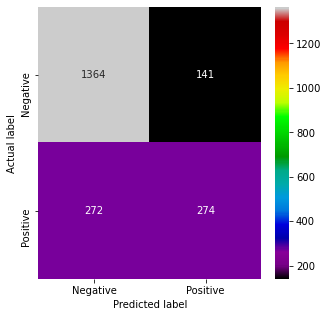

In [34]:
random_cm = confusion_matrix(y_val, random_y_pred)
annot_kws = {"ha": 'center',"va": 'center'}


plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="nipy_spectral")
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

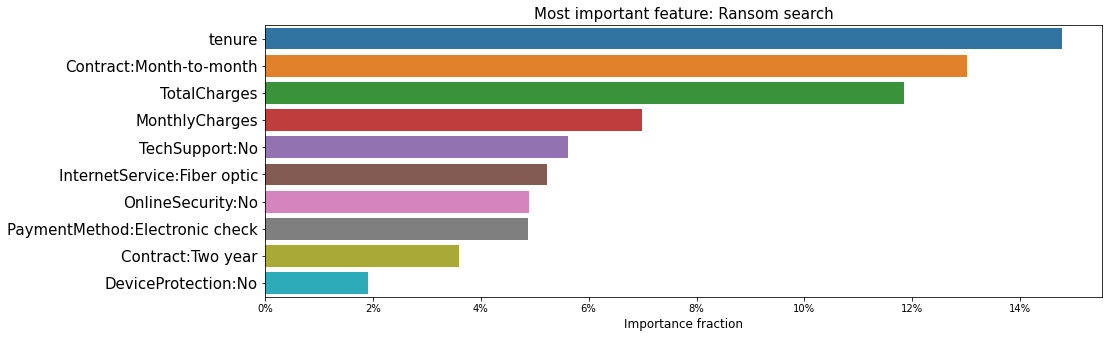

In [35]:
random_feature_importances = [(list(X.columns)[i], random_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
random_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(random_feature_importances, 10, 'Ransom search')

In [36]:
print(classification_report(y_val,random_y_pred))

precision    recall  f1-score   support

           0       0.84      0.90      0.87      1505
           1       0.66      0.52      0.58       546

    accuracy                           0.80      2051
   macro avg       0.75      0.71      0.73      2051
weighted avg       0.79      0.80      0.79      2051



In [37]:
print("Accuracy:",metrics.accuracy_score(y_val, random_y_pred))

Accuracy: 0.8010726474890297


# Comparison

## ROC Curve

In [38]:
fpr_grid, tpr_grid, _ = roc_curve(y_val, grid_y_pred)
fpr_grid_sel, tpr_grid_sel, _ = roc_curve(y_val, grid_y_pred_sel)
fpr_random, tpr_random, _ = roc_curve(y_val, random_y_pred)

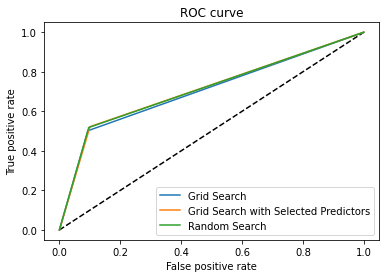

ROC AUC for Grid Search: 0.704
ROC AUC for Grid Search with selected predictors: 0.711
ROC AUC for Random Search: 0.711


In [44]:
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grid, tpr_grid, label='Grid Search')
plt.plot(fpr_grid_sel, tpr_grid_sel, label='Grid Search with Selected Predictors')
plt.plot(fpr_random, tpr_random, label='Random Search')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

roc_auc_grid = roc_auc_score(y_val, grid_y_pred)
print('ROC AUC for Grid Search: %.3f' % roc_auc_grid)
roc_auc_grid_sel = roc_auc_score(y_val, grid_y_pred_sel)
print('ROC AUC for Grid Search with selected predictors: %.3f' % roc_auc_grid_sel)
roc_auc_random = roc_auc_score(y_val, random_y_pred)
print('ROC AUC for Random Search: %.3f' % roc_auc_random)

We observe that all three methods are better than a random prediction. The Grid Search with Selected Predictors has slightly better prediction than the Random Search, which has in turn slightly better prediction than the basic Grid Search.

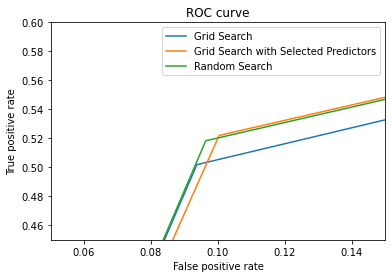

In [45]:
plt.figure(1)
plt.xlim(0.05, 0.15)
plt.ylim(0.45, 0.6)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grid, tpr_grid, label='Grid Search')
plt.plot(fpr_grid_sel, tpr_grid_sel, label='Grid Search with Selected Predictors')
plt.plot(fpr_random, tpr_random, label='Random Search')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Precision - Recall Curve

In [46]:
grid_precision, grid_recall, _ = precision_recall_curve(y_val, grid_y_pred)
grid_precision_sel, grid_recall_sel, _ = precision_recall_curve(y_val, grid_y_pred_sel)
random_precision, random_recall, _ = precision_recall_curve(y_val, random_y_pred)

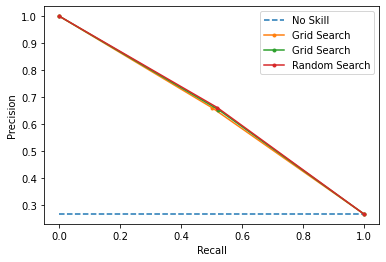

Precision-Recall AUC for Grid Search: 0.647
Precision-Recall AUC for Grid Search with selected predictors: 0.651
Precision-Recall AUC for Random Search: 0.654


In [47]:
y_val = np.array(y_val)
no_skill = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(grid_recall, grid_precision, marker='.', label='Grid Search')
pyplot.plot(grid_recall_sel, grid_precision_sel, marker='.', label='Grid Search')
pyplot.plot(random_recall, random_precision, marker='.', label='Random Search')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='best')
pyplot.show()

pr_auc_grid = auc(grid_recall, grid_precision)
print('Precision-Recall AUC for Grid Search: %.3f' % pr_auc_grid)
pr_auc_grid_sel = auc(grid_recall_sel, grid_precision_sel)
print('Precision-Recall AUC for Grid Search with selected predictors: %.3f' % pr_auc_grid_sel)
pr_auc_random = auc(random_recall, random_precision)
print('Precision-Recall AUC for Random Search: %.3f' % pr_auc_random)